# Outline

- Background to Project
- Code Imports
- Import Data
- Models
    - (Models = KNN, LR, RF, AdaBoost, Gradient, XG Boost, NN-tanh, NN-Relu)
        - Build Pipeline
        - GridSearch
            - Parameter Grid
            - Construct GridSearch
            - Fit GridSearch
            - Output Best Accuracy
            - Save Model's Best Accuracy to Summary Table
        - (From RF take feature importance)
        - (Gradient = XG Boost?)
- Evaluate Best model
    - Confusion Matrix for best model
- Function to predict next fight
- Conclusion
    - Future Work
    

# Code Imports

## Library Installations

In [128]:
# !conda install py-xgboost

## Import Libraries

In [129]:
# For Dataframes and arrays
import numpy as np
import pandas as pd
# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Preprocessing Data
    # Train:Test split
from sklearn.model_selection import train_test_split
    # Scaling
from sklearn.preprocessing import StandardScaler
    # Feature Extraction
from sklearn.decomposition import PCA

# Modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
    # Prevent Kernel Dying
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Neural Network
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras.models import Sequential
from keras.optimizers import SGD

# Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Set random seeds
np.random.seed(123)
tf.set_random_seed(123)

import datetime
import pickle
import random

## Local Code Imports - Do not delete

In [130]:
# DO NOT REMOVE THESE
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
# DO NOT REMOVE This
%reload_ext autoreload

In [132]:
## DO NOT REMOVE
## import local src module -
## src in this project will contain all your local code
## clean_data.py, model.py, visualize.py, custom.py
from src import make_data as mk
from src import visualize as viz
from src import model as mdl
from src import pandas_operators as po
from src import custom as cm

def test_src():
    mk.test_make_data()
    viz.test_viz()
    mdl.test_model()
    po.test_pandas()
    
    return 1

In [133]:
test_src()

In make_data
In Visualize
In Model
In pandas ops


1

# Project Background

## UFC Background

In [134]:
# Credit to National Geographic
cm.ufc_intro_vid()

## Project Objective

### Compare a Variety of Machine Learning Models
For this project we are classifying. There are many choices of classification algorithm, each with its own strengths and weaknesses. There is no single classifier that always works best across all scenarios so we will compare a handful of different learning algorithms to select the best model for our particular problem.

### Assumptions made
- In reality, each bout has 4 possible outcomes; fighter 1 wins, fighter 2 wins, draw or no contest.  For simplicity of modeling, these outcomes have been reduced to simply fighter 1 wins or fighter 2 wins.  
- The models are trained on fighter statistics that reflect their current statistics, not those at the time of the fight.  i.e. a fighter's first bout will feature their statistics the same statistics as their latest bout.

# Import Data

In [135]:
data = pd.read_csv('../data/processed/combined')
data.head(3)

,date,fighter1,fighter2,winner_is_fighter1,title_fight,fighter1_win,fighter1_lose,fighter1_total_bouts,fighter1_win_rate,fighter1_height_inches,...,fighter2_slpm,fighter2_str_acc,fighter2_sapm,fighter2_str_def,fighter2_td_avg,fighter2_td_acc,fighter2_td_def,fighter2_sub_avg,fighter1_age,fighter2_age
0,2018-11-17,Neil Magny,Santiago Ponzinibbio,0,0,21,8,29,0.72,75.0,...,4.27,39,4.02,64,0.54,44,60,0.0,31.0,32.0
1,2018-11-17,Darren Elkins,Ricardo Lamas,0,0,25,7,32,0.78,70.0,...,2.87,45,2.61,59,1.66,32,47,1.0,28.0,30.0
2,2018-11-17,Johnny Walker,Khalil Rountree Jr.,1,0,15,3,18,0.83,77.0,...,2.30,34,3.29,38,0.00,0,50,0.3,31.0,29.0


In [136]:
fighters = pd.read_csv('../data/processed/fighters_cleaned')
fighters.drop(labels=['draw'], axis=1, inplace=True)
fighters.head(3)

,name,dob,win,lose,total_bouts,win_rate,height_inches,reach,stance_open_stance,stance_orthodox,...,stance_southpaw,stance_switch,slpm,str_acc,sapm,str_def,td_avg,td_acc,td_def,sub_avg
0,Luciano Azevedo,1981-06-25,16,9,25,0.64,75.0,72.0,0,1,...,0,0,0.76,45,1.97,27,2.28,11,0,0.0
1,Gleidson Cutis,1989-02-07,7,3,10,0.70,69.0,72.0,0,1,...,0,0,2.99,52,8.28,59,0.00,0,0,0.0
2,Rolando Dy,1990-08-11,9,7,16,0.56,68.0,69.0,0,1,...,0,0,3.04,37,4.47,52,0.30,20,68,0.0


In [137]:
bouts = pd.read_csv('../data/processed/bouts_cleaned')
bouts.head(3)

,date,location,fighter1,fighter2,winner_is_fighter1,title_fight,method_DEC,method_DQ,method_KO/TKO,method_SUB
0,2018-11-17,Argentina,Neil Magny,Santiago Ponzinibbio,0,0,0,0,1,0
1,2018-11-17,Argentina,Darren Elkins,Ricardo Lamas,0,0,0,0,1,0
2,2018-11-17,Argentina,Johnny Walker,Khalil Rountree Jr.,1,0,0,0,1,0


## Train-Test Split

In [138]:
X = data.drop(['date', 'fighter1', 'fighter2', 'winner_is_fighter1'],axis=1)
y = data['winner_is_fighter1']

- We no longer require the fighter names

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

print('X_Train: \n\tObservations: {} \tFeatures: {} \t{}% of data'.format(X_train.shape[0], X_train.shape[1], len(X_train)/len(X)*100))
print('X_Test: \n\tObservations: {} \tFeatures: {} \t{}% of data'.format(X_test.shape[0], X_test.shape[1], len(X_test)/len(X)*100))

X_Train: 
	Observations: 3199 	Features: 41 	70.0% of data
X_Test: 
	Observations: 1371 	Features: 41 	30.0% of data


- We set the random state so that our results can be reproduced easily
- The stratify argument ensures that we maintain the proportion of class labels, i.e. the same proportion of fighter 1 wins to fighter 2 wins, across the original data, y_train and y_test.

In [140]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

- Many of the features are type integer.  Several of the models we will run prefer to have type float as an input

## Scaling

- Many of the machine learning and optimization algorithms that we will be using require feature scaling in order to optimize performance. 
- We will standardize the features using StandardScaler from scikit-learn's preprocessing module.
    - This will transform the data, resulting in each feature having a mean of 0 and a standard deviation of 1.

In [141]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

- We will use the same scaling parameters to standardize the test set, so that the values in the training and test dataset are comparable to each other.

# Models

**Compare Several Models**

- For this project we are classifying bouts.  There are many choices of classification algorithm, each with its own strengths and weaknesses.  
- There is no single classifier that always works best across all scenarios so we will compare a handful of different learning algorithms to select the best model for our particular problem.  

**Cross Validation**

- Train-test splitting does not ensure a 'random' split, which may result in our models overfitting our data.  We can use *cross-validation* to mitigate this issue.
- There are several varieties of cross validation available in [SK Learn's Model Selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
- We will be using K-Fold Cross Validation, with a K of 5 
    - We use each fold as a validation set, with the remaining folds used to train our model
    - The computational cost will increase with each increase in the number of folds.
        - Our dataset is relatively small so this should not be a big problem.

**Track each model's statistics**
- We will keep track of each models statistics and performance in a dataframe

In [142]:
models_summary = pd.DataFrame()
models_summary.rename_axis('Model', axis='columns', inplace=True)

**Accuracy is our best metric**
- Although there are many metrics to evaluate our models against one another, the *Occam's Razor* principle can often be applied (That is, that the simpler explanation is to be preferred). In the case of comparing our models, we are most interested in how many fights we correctly predict, i.e. the accuracy. There is virtually no class imbalance and the cost associated with a false positive and a false negative are identical.

## Baseline Model

- Our Base Rate will be to classify every bout as the largest class
- Our Null Rate will be the accuracy of trivially predicting the most-frequent class

In [143]:
baseline_accuracy = cm.model_baseline(y_train)

# Save the Baseline Model to our models summary dataframe
models_summary['Baseline'] = [baseline_accuracy]  

Fighter 1 wins: 1594
Fighter 2 wins: 1605

Our Baseline Model will always predict Fighter 2 wins
Null Rate: 50.17%


In [144]:
models_summary.rename({0: 'Accuracy'}, inplace=True)
models_summary

Model,Baseline
Accuracy,0.501719


## K-Nearest Neighbors

**Why Use KNN?**
- K-Nearest Neighbors (KNN) is a instance-based learning type of nonparamteric model. It memorizes the training dataset and adapts immediately as we collect new training data.
- The computational complexity for classifying new samples grows linearly with the number of samples in the training dataset. i.e. with every bout that occurs, and updates the model, the model becomes slower and slower to run. Our dataset is relatively very small so we are able to use this model
- We are using the default Minkowski distance, which requires our distances to be standardized.

**Dimensionality Reduction using PCA**
- Principle Component Analysis (PCA) is a form of feature extraction, where we transform the data onto a new feature space whilst maintaining most of the relevant information.
- Main benefits of PCA:
    - Improves computational efficiency of our learning algorithm
    - Reduces the "curse of dimensionality", which can improve the predictive performance

The top 30 principal components explains 97.91% of the variance


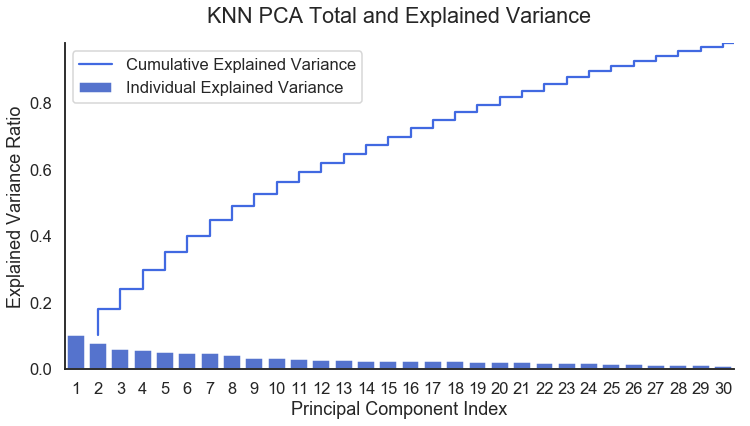

In [145]:
cm.plot_explained_variance(X_train_std,
                           features_to_show=30,
                           title='KNN PCA Total and Explained Variance')

**Choosing the right number of neighbors (k)**
- This is critical to avoid over and underfitting our model.
- We can do this manually by plotting the accuracy of the KNN model, as we change the k value.  
- Our classification is binary, so we should choose k to be an odd number to avoid tied votes.

Highest Accuracy is 65.86%, when K is 25


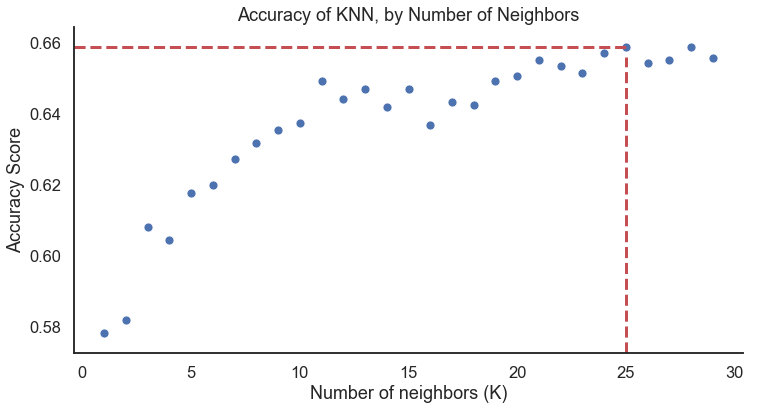

In [146]:
cm.acc_by_k_value(X_train_std, y_train, X_test_std, y_test)

- The best K is the one that results in the highest test accuracy score. 
    - The problem with using the chart above is that we are inadvertently using our test set as a training set. We are forcing the model to fit the test set, and causing the model to overfit.
- A better approach is to use **k-fold cross validation**.
    - This will allow us to compare hyperparameters (such as number of neighbors) on a validation set, and then only use the test data to represent how well the model performs on unseen data

In [147]:
cm.model_knn_grid(X_train, y_train)

Best Accuracy: 64.96%

Best Params:
 {'clf__n_neighbors': 21}


In [148]:
knn_accuracy = cm.model_knn(X_train_std, y_train, X_test_std, y_test, n_neighbors=21)

# Add KNN results to models summary dataframe
models_summary['KNN'] = [knn_accuracy]

Accuracy for K-Nearest Neighbors model (k = 21): 65.5%


In [149]:
models_summary

Model,Baseline,KNN
Accuracy,0.501719,0.654996


## Logistic Regression

In [150]:
cm.model_logreg_grid(X_train_std, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Accuracy: 70.37%

Best params:
 {'clf__C': 0.1}


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.9s finished


In [151]:
lr_accuracy = cm.model_logreg(C_=0.1, X_train_=X_train_std, y_train_=y_train, X_test_=X_test_std, y_test_=y_test)

Accuracy for Logistic Regression model: 71.3%


In [152]:
# Add Logistic Regression results to models summary dataframe
models_summary['Logistic Regression'] = lr_accuracy

In [153]:
models_summary

Model,Baseline,KNN,Logistic Regression
Accuracy,0.501719,0.654996,0.712619


## Random Forest

- Because this is an ensemble algorithm, the model is naturally resistant to noise and variance in the data (which helps reduce overfitting), and generally tends to perform quite well.
- As it is an ensemble alogorithm we have the computational cost of training each model

In [154]:
X_train_top_features = X_train.copy()
X_train_top_features = cm.rename_top_features(X_train_top_features)

In [155]:
cm.model_rf_grid(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best accuracy: 0.698031

Best params:
 {'clf__max_depth': 5, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.05, 'clf__n_estimators': 120}


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.1min finished


In [156]:
rf_accuracy = cm.model_random_forest(X_train_top_features, y_train, X_test, y_test, 
                   max_depth_=5, min_samples_leaf_=0.05, 
                   min_samples_split_=0.05, n_estimators_=120)

# Add Random Forest results to models summary dataframe
models_summary['Random Forest'] = rf_accuracy 

Accuracy for Random Forest model : 70.5%


In [157]:
models_summary

Model,Baseline,KNN,Logistic Regression,Random Forest
Accuracy,0.501719,0.654996,0.712619,0.704595


## AdaBoost

In [158]:
cm.model_ada_boost_grid(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.8s finished


Best Accuracy: 70.46%

Best params:
 {'clf__learning_rate': 0.5, 'clf__n_estimators': 90}


In [159]:
ada_accuracy = cm.model_ada_boost(X_train, y_train, X_test, y_test,
                                  learning_rate=0.5, n_estimators=90)

Accuracy for Ada Boost model : 71.4%


In [160]:
# Add Ada Boost results to models summary dataframe
models_summary['Ada Boost'] = ada_accuracy

In [161]:
models_summary

Model,Baseline,KNN,Logistic Regression,Random Forest,Ada Boost
Accuracy,0.501719,0.654996,0.712619,0.704595,0.714077


## Gradient Boosting (XG Boost)

- eXtreme Gradient Boosting (XG Boost) is a form of gradient boosting which often produces the best performances, amongst gradient boosting algorithms
- XG Boost is able to parallelize the construction of decision trees across all our computer's CPU cores during the training phase
    - This can even be done across a cluster of computers 

In [162]:
xgb_accuracy = cm.model_xgboost(X_train, y_train, X_test, y_test)[0]
models_summary['XG Boost'] = xgb_accuracy

Accuracy for XGBoost model : 73.7%


In [163]:
models_summary

Model,Baseline,KNN,Logistic Regression,Random Forest,Ada Boost,XG Boost
Accuracy,0.501719,0.654996,0.712619,0.704595,0.714077,0.736689


## Neural Network (tanh)

In [164]:
model_tanh = cm.model_compile_neural_network(X_train_std, 'tanh')

In [165]:
history_tanh = cm.model_fit_neural_network(X_train_std, y_train, model_tanh, 100)

We have reduced the loss by 22.03% by training the model through 100 epochs


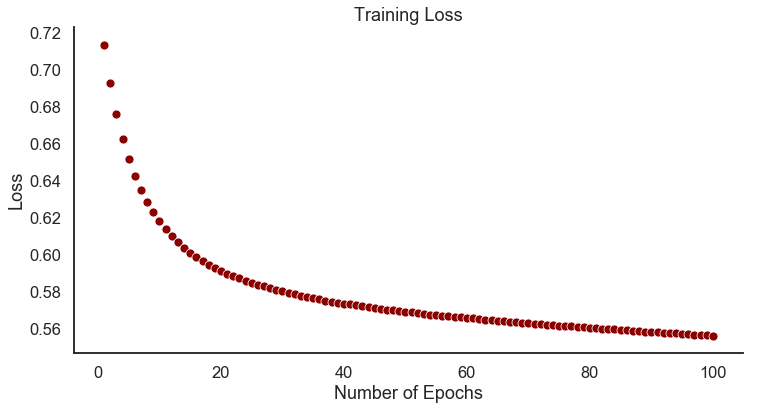

In [166]:
loss = history_tanh.history['loss']
cm.plot_training_loss(loss)

We have increased the accuracy by 34.85% by training the model through 100 epochs


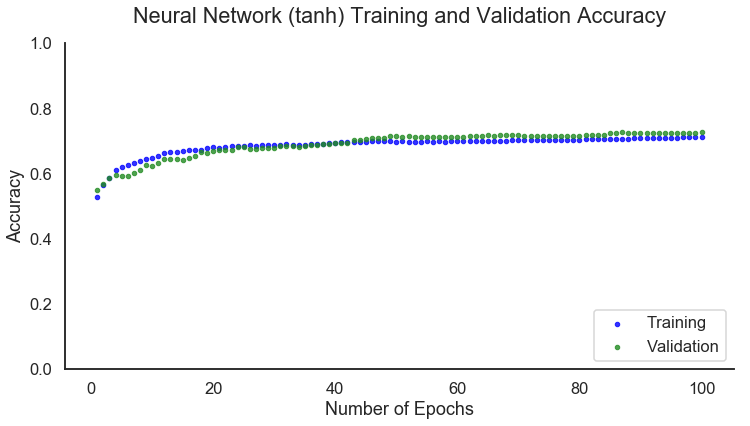

In [167]:
acc = history_tanh.history['acc']
val_acc = history_tanh.history['val_acc']

cm.training_and_validation_accuracy(acc, val_acc, history_tanh,
                                      title='Neural Network (tanh) Training and Validation Accuracy')

We have increased the accuracy by 34.85% by training the model through 100 epochs


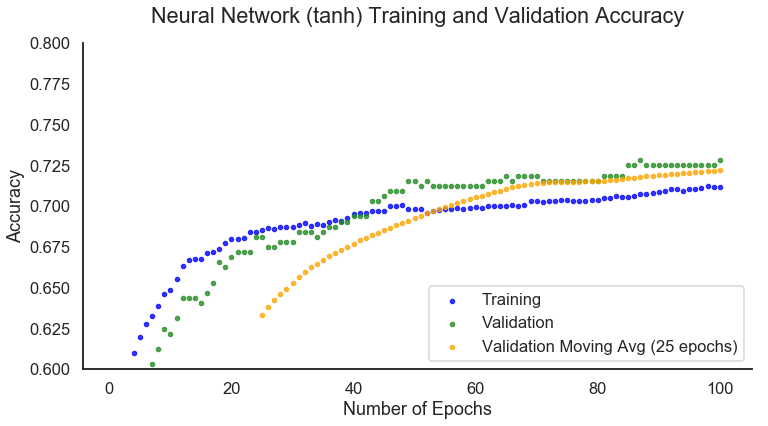

In [168]:
cm.training_and_validation_accuracy(acc, val_acc, history_tanh,
                                      title='Neural Network (tanh) Training and Validation Accuracy',
                                      y_lim=(0.6,0.8), show_mov_avg=True)

In [169]:
nn_tanh_accuracy = cm.model_test_acc_neural_network(X_test_std, y_test, model_tanh)

# Add Score to Models Summary DataFrame
models_summary['Neural Network (tanh)'] = nn_tanh_accuracy

Test Accuracy: 71.0%


In [170]:
models_summary

Model,Baseline,KNN,Logistic Regression,Random Forest,Ada Boost,XG Boost,Neural Network (tanh)
Accuracy,0.501719,0.654996,0.712619,0.704595,0.714077,0.736689,0.709701


## Neural Network (Relu)

In [171]:
model_relu = cm.model_compile_neural_network(X_train_std, 'relu')

In [172]:
history_relu = cm.model_fit_neural_network(X_train_std, y_train, model_relu, 100)

We have reduced the loss by 23.0% by training the model through 100 epochs


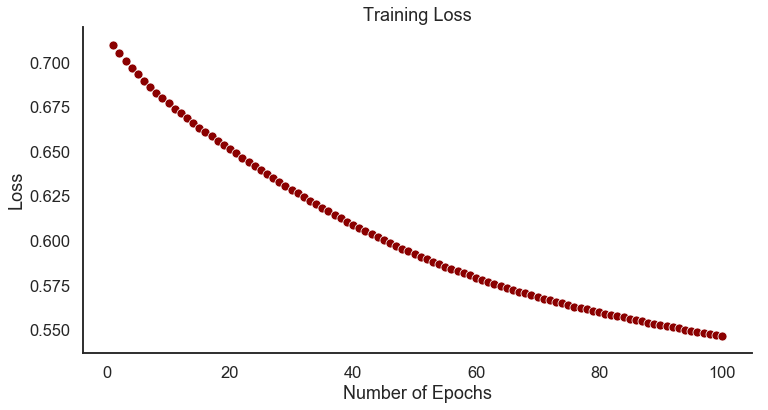

In [173]:
loss = history_relu.history['loss']
cm.plot_training_loss(loss)

We have increased the accuracy by 42.32% by training the model through 100 epochs


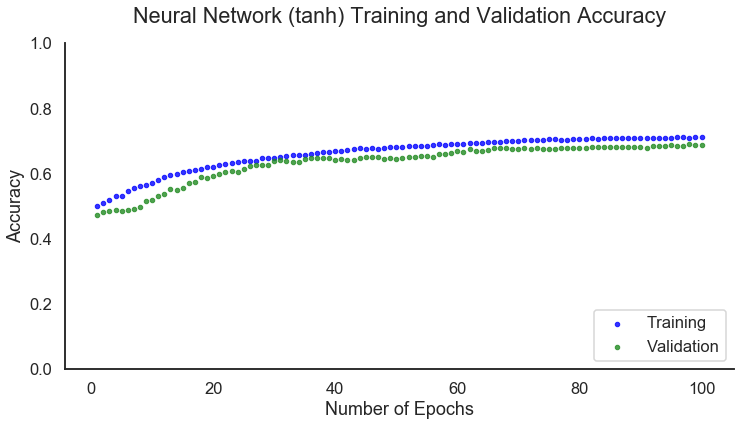

In [174]:
acc = history_relu.history['acc']
val_acc = history_relu.history['val_acc']

cm.training_and_validation_accuracy(acc, val_acc, history_relu,
                                      title='Neural Network (tanh) Training and Validation Accuracy')

We have increased the accuracy by 42.32% by training the model through 100 epochs


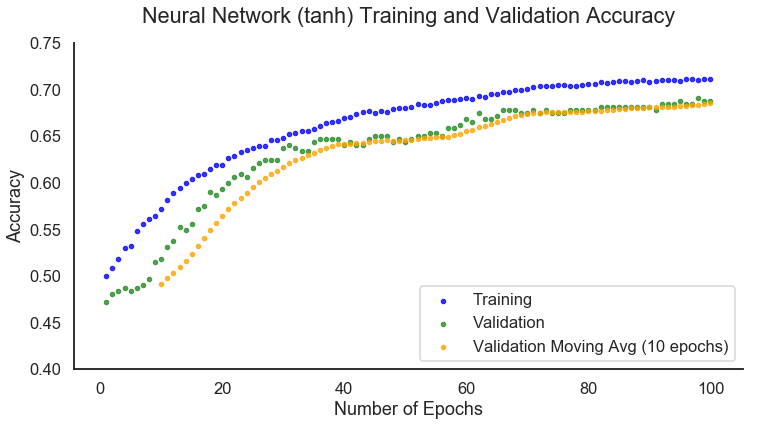

In [175]:
acc = history_relu.history['acc']
val_acc = history_relu.history['val_acc']

cm.training_and_validation_accuracy(acc, val_acc, history_relu,
                                      title='Neural Network (tanh) Training and Validation Accuracy',
                                   y_lim=(0.4,0.75), 
                                   mov_avg_n=10,
                                   show_mov_avg=True)

In [176]:
nn_relu_accuracy = cm.model_test_acc_neural_network(X_test_std, y_test, model_relu)

# Add Score to Models Summary DataFrame
models_summary['Neural Network (relu)'] = nn_relu_accuracy

Test Accuracy: 70.0%


In [177]:
models_summary

Model,Baseline,KNN,Logistic Regression,Random Forest,Ada Boost,XG Boost,Neural Network (tanh),Neural Network (relu)
Accuracy,0.501719,0.654996,0.712619,0.704595,0.714077,0.736689,0.709701,0.695113


# Evaluation of Models

In [178]:
models_summary = models_summary.T

# Sort models_summary into order
models_summary.sort_values('Accuracy', inplace=True)

models_summary

,Accuracy
Model,
Baseline,0.501719
KNN,0.654996
Neural Network (relu),0.695113
Random Forest,0.704595
Neural Network (tanh),0.709701
Logistic Regression,0.712619
Ada Boost,0.714077
XG Boost,0.736689


## Barchart to compare Models

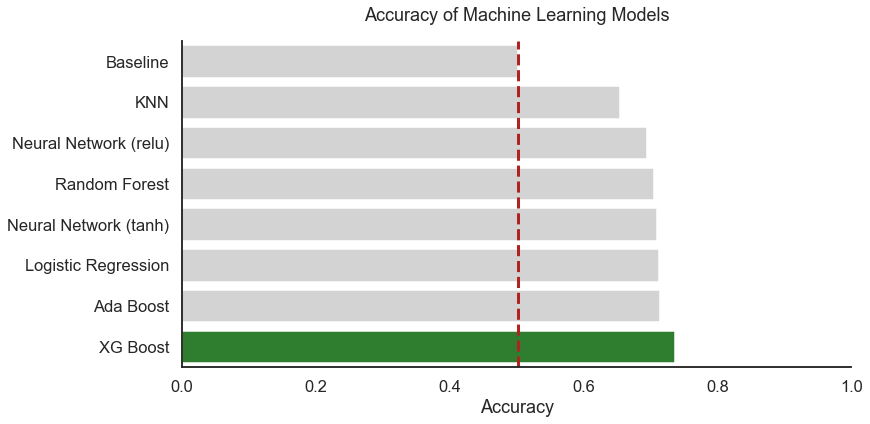

In [179]:
cm.plot_compare_models(models_summary, 'Accuracy')

- We can see that XG Boost has the highest accuracy with 73.7%

## Confusion Matrix of Best Model

Accuracy for XGBoost model : 73.7%
Accuracy for XGBoost model : 73.7%
Normalized confusion matrix



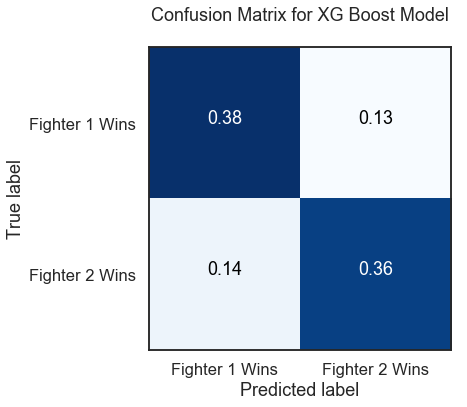

In [180]:
# XG Boost
y_test = cm.model_xgboost(X_train, y_train, X_test, y_test)[2]
y_test_pred = cm.model_xgboost(X_train, y_train, X_test, y_test)[3]

conf_matrix = confusion_matrix(y_test,y_test_pred)
cm.plot_confusion_matrix(cm=conf_matrix, classes=['Fighter 1 Wins','Fighter 2 Wins'], normalize=True, title='Confusion Matrix for XG Boost Model');

# Function to Predict a Fight

In [181]:
# Generate a random list of fighter names
cm.random_fighter_names(fighters, num_fighters=5)

,5 Random Fighter Names
0,Joe Soto
1,Rory Markham
2,Roosevelt Roberts
3,Andreas Stahl
4,Paul Ruiz


In [182]:
# Generate a list of names that contain a given string
cm.fighter_name_contains('Adam')[:5]

Names that contain "Adam"


,name
60,Adam Piccolotti
341,Adam Milstead
363,Adam Meredith
503,Adam Lynn
1422,Adam Cella


In [184]:
cm.predict_fight(data, fighters)

What is the name of Fighter 1?	Conor McGregor
What is the name of Fighter 2?	Adam Lynn
When will the fight take place? (YYYY-MM-DD) (default = today)	
Is this a title fight? (yes/no)	no

I think that Conor McGregor will beat Adam Lynn.
I am 98.91% sure of this


## Predict a recent bout, not in our dataset

- UFC 240 took place on July 27th 2019.  The headline fight was between Max Holloway and Frankie Edgar.  We will use the model to predict the outcome of the fight

In [ ]:
cm.predict_fight(data, fighters)

- The model worked for last weekend's UFC 240 Main Fighter

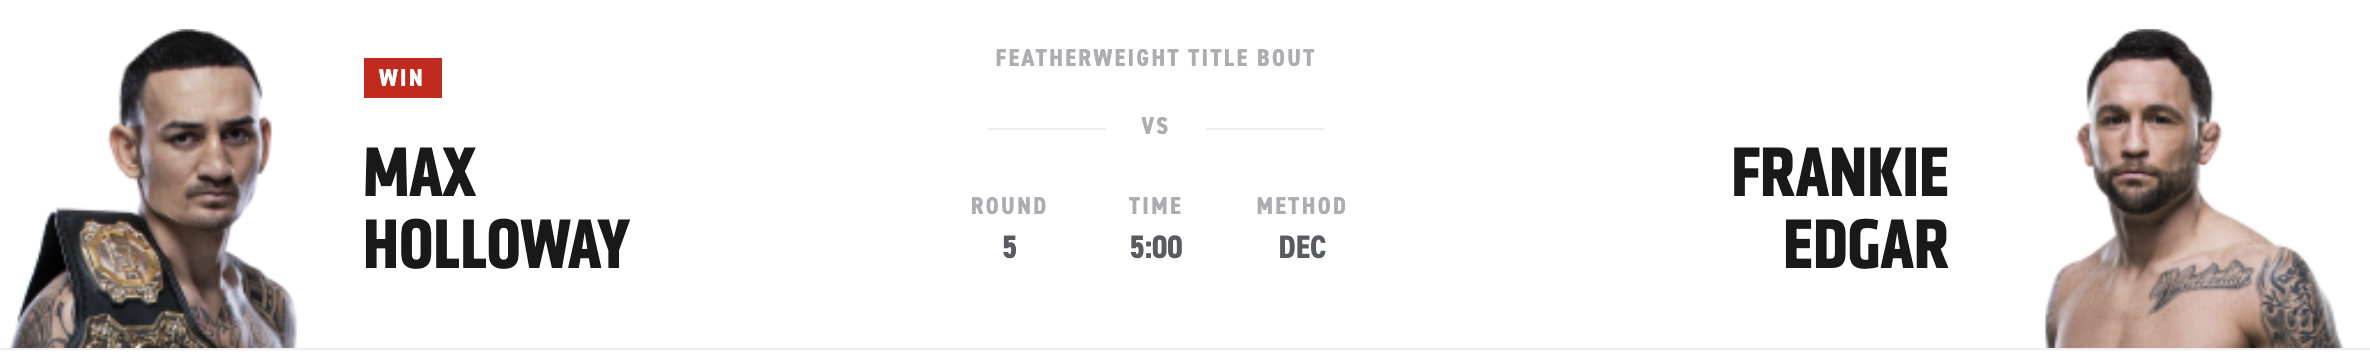

# Conclusion

## Future Work
- Fighter Statistics is not reflective of their statistics at time of fight (i.e. our models are training on fighter statistics that are an aggregate of their career, not up until the time of the fight)
    - Data would be needed on every fight a fighter has had in their career, and then a class of fighter could be made and updated with each bout.  
- Include a draw outcome.  This would create a multiclass target variable.  Models such as logistic regression would have to be adapted (to One-Vs-All)
- Include how the fight was finished as part of prediction (i.e. Submission, KO, Decision)
- Ensemble method of average of output probabilities.